# Objective

The goals are to:

Learn a model to predict a class label for a bag of instances.
Find out which instances within the bag caused a position class label prediction.

### **Implementation** 
The following steps describe how the model works:

The feature extractor layers extract feature embeddings.
The embeddings are fed into the MIL attention layer to get the attention scores. The layer is designed as permutation-invariant.
Input features and their corresponding attention scores are multiplied together.
The resulting output is passed to a softmax function for classification.

# Installation of Packages

In [268]:
# !pip install -q tensorflow_datasets
# !pip install datasets
# !pip install keras_cv
# !pip install keras_hub

# Download Dataset from external source

# Importing packages

In [269]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import  metrics
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras import callbacks
from tensorflow.keras import ops
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras import applications
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.datasets import mnist
from tqdm import tqdm

# from tensorflow.keras.datasets import mnist
# import tensorflow_datasets as tfds
# from keras.applications import EfficientNetB0
# import keras_cv
# import keras_hub

# Custom Functions

# Reading Data

In [270]:
(x_train, y_train), (x_val, y_val) = mnist.load_data()

# Data Inspection / Visualization

In [271]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [272]:
tf.unique(y_train)[0].numpy()

array([5, 0, 4, 1, 9, 2, 3, 6, 7, 8], dtype=uint8)

In [273]:
numRows  = x_train.shape[0]
numRows

60000

  0%|          | 0/1 [02:59<?, ?it/s]


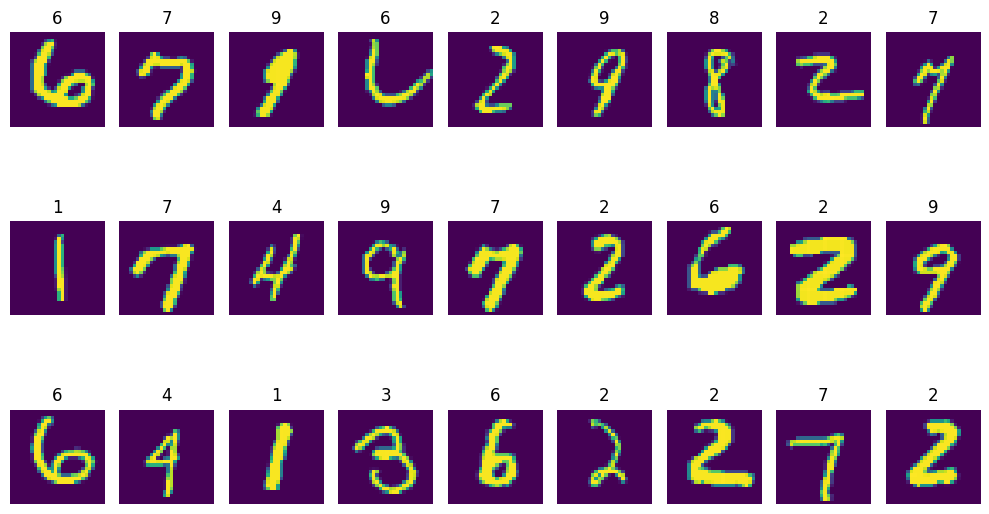

In [274]:
plt.figure(figsize=(10,8))
randomIndex = np.random.randint(0, numRows, 27)
for i in range(27):
    plt.subplot(4, 9, i+1)
    item = x_train[int(randomIndex[i])]
    plt.imshow(item)
    plt.title(y_train[int(randomIndex[i])])
    plt.axis(False)


plt.tight_layout()

# Data Preprocessing

In [275]:
# Constants

POSITIVE_CLASS = 1
BAG_COUNT = 1000
VAL_BAG_COUNT = 300
BAG_SIZE = 3
PLOT_SIZE = 3
ENSEMBLE_AVG_COUNT = 1

In [276]:
uniqueLabel, idx = tf.unique(y_train)
num_classes = uniqueLabel.shape[0]

input_shape = (28, 28, 1)
num_classes

10

In [277]:
np.random.choice(6, 5, replace=True)

array([1, 3, 5, 3, 2])

In [278]:
def create_bags(input_data, input_labels, positive_class, bag_count, instance_count):
    # Set up bags.
    bags = []
    bag_labels = []

    # Normalize input data.
    input_data = np.divide(input_data, 255.0)

    # Count positive samples.
    count = 0

    for _ in range(bag_count):
        # Pick a fixed size random subset of samples.
        index = np.random.choice(input_data.shape[0], instance_count, replace=False)
        instances_data = input_data[index]
        instances_labels = input_labels[index]

        # By default, all bags are labeled as 0.
        bag_label = 0

        # Check if there is at least a positive class in the bag.
        if positive_class in instances_labels:
            # Positive bag will be labeled as 1.
            bag_label = 1
            count += 1

        bags.append(instances_data)
        bag_labels.append(np.array([bag_label]))

    print(f"Positive bags: {count}")
    print(f"Negative bags: {bag_count - count}")

    return (list(np.swapaxes(bags, 0, 1)), np.array(bag_labels))

In [279]:
train_data, train_labels = create_bags(
    x_train, y_train, POSITIVE_CLASS, BAG_COUNT, BAG_SIZE
)

Positive bags: 273
Negative bags: 727


In [280]:
val_data, val_labels = create_bags(
    x_val, y_val, POSITIVE_CLASS, VAL_BAG_COUNT, BAG_SIZE
)

Positive bags: 82
Negative bags: 218


In [281]:
#x_train = x_train.astype("float32") / 255
#x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
#x_train = np.expand_dims(x_train, -1)
#x_test = np.expand_dims(x_test, -1)

In [282]:
#print("x_train shape:", x_train.shape)
#print(x_train.shape[0], "train samples")
#print(x_test.shape[0], "test samples")

In [283]:
#y_train = utils.to_categorical(y_train, num_classes)
#y_test = utils.to_categorical(y_test, num_classes)

# Data Postprocessing

In [284]:
def plot(data, labels, bag_class, predictions=None, attention_weights=None):
    """ "Utility for plotting bags and attention weights.

    Args:
      data: Input data that contains the bags of instances.
      labels: The associated bag labels of the input data.
      bag_class: String name of the desired bag class.
        The options are: "positive" or "negative".
      predictions: Class labels model predictions.
      If you don't specify anything, ground truth labels will be used.
      attention_weights: Attention weights for each instance within the input data.
      If you don't specify anything, the values won't be displayed.
    """
    return  ## TODO
    labels = np.array(labels).reshape(-1)

    if bag_class == "positive":
        if predictions is not None:
            labels = np.where(predictions.argmax(1) == 1)[0]
            bags = np.array(data)[:, labels[0:PLOT_SIZE]]

        else:
            labels = np.where(labels == 1)[0]
            bags = np.array(data)[:, labels[0:PLOT_SIZE]]

    elif bag_class == "negative":
        if predictions is not None:
            labels = np.where(predictions.argmax(1) == 0)[0]
            bags = np.array(data)[:, labels[0:PLOT_SIZE]]
        else:
            labels = np.where(labels == 0)[0]
            bags = np.array(data)[:, labels[0:PLOT_SIZE]]

    else:
        print(f"There is no class {bag_class}")
        return

    print(f"The bag class label is {bag_class}")
    for i in range(PLOT_SIZE):
        figure = plt.figure(figsize=(8, 8))
        print(f"Bag number: {labels[i]}")
        for j in range(BAG_SIZE):
            image = bags[j][i]
            figure.add_subplot(1, BAG_SIZE, j + 1)
            plt.grid(False)
            if attention_weights is not None:
                plt.title(np.around(attention_weights[labels[i]][j], 2))
            plt.imshow(image)
        plt.show()


# Plot some of validation data bags per class.
plot(val_data, val_labels, "positive")
plot(val_data, val_labels, "negative")

# Model

In [285]:
class MILAttentionLayer(layers.Layer):
    """Implementation of the attention-based Deep MIL layer.

    Args:
      weight_params_dim: Positive Integer. Dimension of the weight matrix.
      kernel_initializer: Initializer for the `kernel` matrix.
      kernel_regularizer: Regularizer function applied to the `kernel` matrix.
      use_gated: Boolean, whether or not to use the gated mechanism.

    Returns:
      List of 2D tensors with BAG_SIZE length.
      The tensors are the attention scores after softmax with shape `(batch_size, 1)`.
    """

    def __init__(
        self,
        weight_params_dim,
        kernel_initializer="glorot_uniform",
        kernel_regularizer=None,
        use_gated=False,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.weight_params_dim = weight_params_dim
        self.use_gated = use_gated

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)

        self.v_init = self.kernel_initializer
        self.w_init = self.kernel_initializer
        self.u_init = self.kernel_initializer

        self.v_regularizer = self.kernel_regularizer
        self.w_regularizer = self.kernel_regularizer
        self.u_regularizer = self.kernel_regularizer

    def build(self, input_shape):
        # Input shape.
        # List of 2D tensors with shape: (batch_size, input_dim).
        input_dim = input_shape[0][1]

        self.v_weight_params = self.add_weight(
            shape=(input_dim, self.weight_params_dim),
            initializer=self.v_init,
            name="v",
            regularizer=self.v_regularizer,
            trainable=True,
        )

        self.w_weight_params = self.add_weight(
            shape=(self.weight_params_dim, 1),
            initializer=self.w_init,
            name="w",
            regularizer=self.w_regularizer,
            trainable=True,
        )

        if self.use_gated:
            self.u_weight_params = self.add_weight(
                shape=(input_dim, self.weight_params_dim),
                initializer=self.u_init,
                name="u",
                regularizer=self.u_regularizer,
                trainable=True,
            )
        else:
            self.u_weight_params = None

        self.input_built = True

    def call(self, inputs):
        # Assigning variables from the number of inputs.
        instances = [self.compute_attention_scores(instance) for instance in inputs]

        # Stack instances into a single tensor.
        instances = ops.stack(instances)

        # Apply softmax over instances such that the output summation is equal to 1.
        alpha = ops.softmax(instances, axis=0)

        # Split to recreate the same array of tensors we had as inputs.
        return [alpha[i] for i in range(alpha.shape[0])]

    def compute_attention_scores(self, instance):
        # Reserve in-case "gated mechanism" used.
        original_instance = instance

        # tanh(v*h_k^T)
        instance = ops.tanh(ops.tensordot(instance, self.v_weight_params, axes=1))

        # for learning non-linear relations efficiently.
        if self.use_gated:
            instance = instance * ops.sigmoid(
                ops.tensordot(original_instance, self.u_weight_params, axes=1)
            )

        # w^T*(tanh(v*h_k^T)) / w^T*(tanh(v*h_k^T)*sigmoid(u*h_k^T))
        return ops.tensordot(instance, self.w_weight_params, axes=1)

In [286]:
def create_model(instance_shape):
    # Extract features from inputs.
    inputs, embeddings = [], []
    shared_dense_layer_1 = layers.Dense(128, activation="relu")
    shared_dense_layer_2 = layers.Dense(64, activation="relu")
    for _ in range(BAG_SIZE):
        inp = layers.Input(instance_shape)
        flatten = layers.Flatten()(inp)
        dense_1 = shared_dense_layer_1(flatten)
        dense_2 = shared_dense_layer_2(dense_1)
        inputs.append(inp)
        embeddings.append(dense_2)

    # Invoke the attention layer.
    alpha = MILAttentionLayer(
        weight_params_dim=256,
        kernel_regularizer= regularizers.L2(0.01),
        use_gated=True,
        name="alpha",
    )(embeddings)

    # Multiply attention weights with the input layers.
    multiply_layers = [
        layers.multiply([alpha[i], embeddings[i]]) for i in range(len(alpha))
    ]

    # Concatenate layers.
    concat = layers.concatenate(multiply_layers, axis=1)

    # Classification output node.
    output = layers.Dense(2, activation="softmax")(concat)

    return models.Model(inputs, output)

In [287]:
#utils.plot_model(model, show_shapes=True)
#model.summary()

# Compile

In [288]:
def train(train_data, train_labels, val_data, val_labels, model):
    # Train model.
    # Prepare callbacks.
    # Path where to save best weights.

    # Take the file name from the wrapper.
    file_path = "/tmp/best_model.weights.h5"

    # Initialize model checkpoint callback.
    model_checkpoint = callbacks.ModelCheckpoint(
        file_path,
        monitor="val_loss",
        verbose=0,
        mode="min",
        save_best_only=True,
        save_weights_only=True,
    )

    # Initialize early stopping callback.
    # The model performance is monitored across the validation data and stops training
    # when the generalization error cease to decrease.
    early_stopping = callbacks.EarlyStopping(
        monitor="val_loss", patience=10, mode="min"
    )

    # Compile model.
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    # Fit model.
    model.fit(
        train_data,
        train_labels,
        validation_data=(val_data, val_labels),
        epochs=20,
        class_weight=compute_class_weights(train_labels),
        batch_size=1,
        callbacks=[early_stopping, model_checkpoint],
        verbose=0,
    )

    # Load best weights.
    model.load_weights(file_path)

    return model




In [289]:
def compute_class_weights(labels):
    # Count number of postive and negative bags.
    negative_count = len(np.where(labels == 0)[0])
    positive_count = len(np.where(labels == 1)[0])
    total_count = negative_count + positive_count

    # Build class weight dictionary.
    return {
        0: (1 / negative_count) * (total_count / 2),
        1: (1 / positive_count) * (total_count / 2),
    }

In [290]:
# Building model(s).
instance_shape = train_data[0][0].shape
modelss = [create_model(instance_shape) for _ in range(ENSEMBLE_AVG_COUNT)]

# Show single model architecture.
print(modelss[0].summary())

# Training model(s).
trained_models = [
    train(train_data, train_labels, val_data, val_labels, model)
    for model in tqdm(modelss)
]

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_57      │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_58      │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_59      │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_57          │ (None, 784)       │          0 │ input_layer_57[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_58          │ (None, 784)       │          0 │ input_layer_58[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_59          │ (None, 784)       │          0 │ input_layer_59[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_52 (Dense)    │ (None, 128)       │    100,480 │ flatten_57[0][0], │
│                     │                   │            │ flatten_58[0][0], │
│                     │                   │            │ flatten_59[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_53 (Dense)    │ (None, 64)        │      8,256 │ dense_52[0][0],   │
│                     │                   │            │ dense_52[1][0],   │
│                     │                   │            │ dense_52[2][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ alpha               │ [(None, 1),       │     33,024 │ dense_53[0][0],   │
│ (MILAttentionLayer) │ (None, 1), (None, │            │ dense_53[1][0],   │
│                     │ 1)]               │            │ dense_53[2][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_42         │ (None, 64)        │          0 │ alpha[0][0],      │
│ (Multiply)          │                   │            │ dense_53[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_43         │ (None, 64)        │          0 │ alpha[0][1],      │
│ (Multiply)          │                   │            │ dense_53[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_44         │ (None, 64)        │          0 │ alpha[0][2],      │
│ (Multiply)          │                   │            │ dense_53[2][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 192)       │          0 │ multiply_42[0][0… │
│ (Concatenate)       │                   │            │ multiply_43[0][0… │
│                     │                   │            │ multiply_44[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_54 (Dense)    │ (None, 2)         │        386 │ concatenate_14[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 142,146 (555.26 KB)

 Trainable params: 142,146 (555.26 KB)

 Non-trainable params: 0 (0.00 B)

None


100%|██████████| 1/1 [00:38<00:00, 38.49s/it]


# Fit

# Evaluation

In [291]:
# score = model.evaluate(x_test, y_test, verbose=0)
# print("Test loss:", score[0])
# print("Test accuracy:", score[1])

In [292]:
def predict(data, labels, trained_models):
    # Collect info per model.
    models_predictions = []
    models_attention_weights = []
    models_losses = []
    models_accuracies = []

    for model in trained_models:
        # Predict output classes on data.
        predictions = model.predict(data)
        models_predictions.append(predictions)

        # Create intermediate model to get MIL attention layer weights.
        intermediate_model = models.Model(model.input, model.get_layer("alpha").output)

        # Predict MIL attention layer weights.
        intermediate_predictions = intermediate_model.predict(data)

        attention_weights = np.squeeze(np.swapaxes(intermediate_predictions, 1, 0))
        models_attention_weights.append(attention_weights)

        loss, accuracy = model.evaluate(data, labels, verbose=0)
        models_losses.append(loss)
        models_accuracies.append(accuracy)

    print(
        f"The average loss and accuracy are {np.sum(models_losses, axis=0) / ENSEMBLE_AVG_COUNT:.2f}"
        f" and {100 * np.sum(models_accuracies, axis=0) / ENSEMBLE_AVG_COUNT:.2f} % resp."
    )

    return (
        np.sum(models_predictions, axis=0) / ENSEMBLE_AVG_COUNT,
        np.sum(models_attention_weights, axis=0) / ENSEMBLE_AVG_COUNT,
    )


# Evaluate and predict classes and attention scores on validation data.
class_predictions, attention_params = predict(val_data, val_labels, trained_models)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
The average loss and accuracy are 0.04 and 99.00 % resp.


In [293]:
plot(
    val_data,
    val_labels,
    "positive",
    predictions=class_predictions,
    attention_weights=attention_params,
)
plot(
    val_data,
    val_labels,
    "negative",
    predictions=class_predictions,
    attention_weights=attention_params,
)

In [294]:
# def make_plot(metric):
#   plt.plot(history.history[metric ])
#   plt.plot(history.history['val_'+metric ])
#   plt.title( 'Model '+metric )
#   plt.ylabel( metric.capitalize() )
#   plt.xlabel( 'Epoch' )
#   plt.legend([ 'Train' , 'Validation' ], loc='upper left' )
#   plt.show()

In [295]:
# make_plot('accuracy')
# make_plot('loss')

# Inference

# Deploy

In [296]:
#model.save("custom_image_classification_model")